In [1]:
import kwant
import numpy as np 
import matplotlib.pyplot as plt

c:\Users\manue\anaconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
# Fundamental constants

pi = np.pi
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
vf = 1e6            # Fermi velocity (m/s)
hbar = h/(2*pi)     # Reduced planck constant

epsilon_0 = 8.85e-12  # Vacuum permittivity (F/m)
epsilon_hBN = 3
epsilon_Ox = 3.8

In [4]:
# Definition of the potential
db = 20e-9 # bottom hBN layer thickness (m)
dOx = 285e-9 # substrate thickness (m)

Cbg = epsilon_0 / (db/epsilon_hBN + dOx/epsilon_Ox)

# We do not have a precise function for the capacitance linked with the CNT, so we use the approximation they provide
r_cnt = 1e-9 # CNT radius (m)
dt = 4e-9 # top hBN thickness (m)
ht = dt + r_cnt
at = np.sqrt(ht**2 - r_cnt**2)
kappa = (ht+at)**2/r_cnt**2

# Here, epsilon_r is set to have a curve resembling the simulation in the article (Ccnt/e evaluated at 0 is around 2.5e12 cm^-2 V^-1)
def computeCcnt(y, epsilon_r=2.5):
    return epsilon_0*epsilon_r*4*at/((y**2+at**2)*np.log(kappa)) # Try log10 if it does not work

def potential(site, Vcnt, Vbg):
    (x, y) = site.pos
    Ccnt = computeCcnt(y*a*1e-9)
    n = (Cbg*Vbg + Ccnt*Vcnt)/e
    U = -np.sign(n)*hbar*vf*np.sqrt(pi*np.abs(n))
    return U/e # Divide by e to obtain electronVolts

In [6]:
# System maker
a0 = 1/(4*np.sqrt(3))
t0 = 3.0

s = 1
a = a0*s
t = t0/s
W = 10
L = 10
W_lead = 10#4

def rectangle(pos, L=L, W=W):
    x, y = pos
    return abs(x) < L//2 and abs(y) < W//2
    
def lead_shape(pos):
    x, y = pos
    return -W//2 < y < W//2 # this is not like in the article (use W_lead instead), but scattering otherwise

def make_system(L, W, a, t):
    lattice = kwant.lattice.honeycomb(a, norbs=1)
    subl1, subl2 = lattice.sublattices
    
    syst = kwant.Builder()
    syst[lattice.shape(rectangle, (0,0))] = potential # Is that line correct?

    hoppings = (((0, 0), subl1, subl2), ((0, 1), subl1, subl2), ((-1, 1), subl1, subl2))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t

    # Create leads
    sym0 = kwant.TranslationalSymmetry(lattice.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[lattice.shape(lead_shape, (0, 0))] = potential
    lead0[lattice.neighbors()]= -t
    lead0.eradicate_dangling()
    syst.attach_lead(lead0)

    sym1 = kwant.TranslationalSymmetry(lattice.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[lattice.shape(lead_shape, (0, 0))] = potential
    lead1[lattice.neighbors()]= -t
    lead1.eradicate_dangling()
    syst.attach_lead(lead1)

    return syst

c:\Users\manue\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


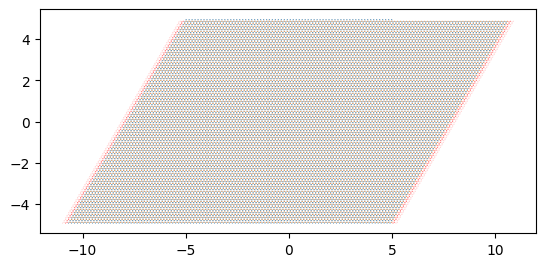

In [7]:
syst = make_system(L, W, a, t)
kwant.plot(syst)
fsyst = syst.finalized()

Text(0, 0.5, 'T')

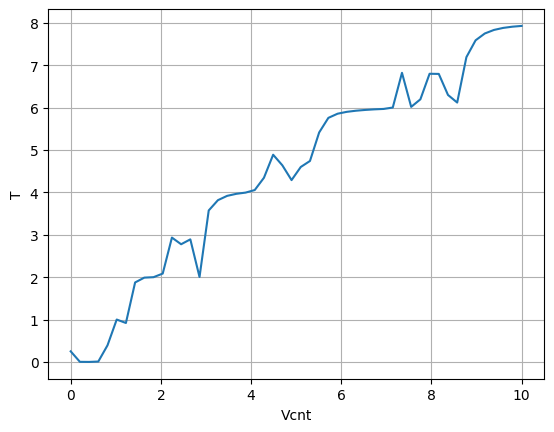

In [6]:
### Plotting T as a function of the energy

VcntArray = np.linspace(0, 10, 50)
T = np.zeros_like(VcntArray)

for i in range(len(T)):
    smatrix = kwant.smatrix(fsyst, energy=0, params=dict(Vcnt=VcntArray[i], Vbg=-13.6))
    T[i] = smatrix.transmission(1, 0)

plt.plot(VcntArray, T)
plt.grid()
plt.xlabel("Vcnt")
plt.ylabel("T")

In [ ]:
import kwant
import numpy as np
import matplotlib.pyplot as plt

# Constants
t = 2.7  # Hopping parameter (eV)
a_cc = 0.142  # Carbon-carbon distance (nm)
a_lat = np.sqrt(3) * a_cc  # Effective lattice constant for graphene
length = 360  # Scattering region length (nm)
width = 360  # Scattering region width (nm)
V_cnt = 3.0  # CNT gate voltage (V)
V_bg = 13.6  # Backgate voltage (V)

# Define graphene lattice
graphene = kwant.lattice.honeycomb(a=a_lat)
a, b = graphene.sublattices  # Sublattices

# Function to define the CNT potential
def cnt_potential(site, V_cnt, center=(0, 0), width=10):
    x, y = site.pos
    dist = np.sqrt((x - center[0])**2 + y**2)
    cnt_contribution = -V_cnt * np.exp(-dist**2 / (2 * width**2))  # Gaussian potential
    bg_contribution = -V_bg
    return cnt_contribution + bg_contribution

# Function to create the graphene system
def make_device(V_cnt, V_bg, cnt_center=(0, 0), cnt_width=10):
    system = kwant.Builder()

    # Define the scattering region
    scattering_region = lambda pos: -length / 2 < pos[0] < length / 2 and -width / 2 < pos[1] < width / 2
    system[graphene.shape(scattering_region, (0, 0))] = lambda site: cnt_potential(site, V_cnt, cnt_center, cnt_width)
    system[graphene.neighbors()] = -t

    # Define leads
    lead_shape_vertical = lambda pos: -width / 2 < pos[1] < width / 2
    lead_shape_horizontal = lambda pos: -length / 2 < pos[0] < length / 2

    # Left lead
    left_lead = kwant.Builder(kwant.TranslationalSymmetry((-a_lat, 0)))
    left_lead[graphene.shape(lead_shape_vertical, (0, 0))] = -V_bg
    left_lead[graphene.neighbors()] = -t
    system.attach_lead(left_lead)

    # Right lead
    right_lead = kwant.Builder(kwant.TranslationalSymmetry((a_lat, 0)))
    right_lead[graphene.shape(lead_shape_vertical, (0, 0))] = -V_bg
    right_lead[graphene.neighbors()] = -t
    system.attach_lead(right_lead)

    # Top lead
    top_lead = kwant.Builder(kwant.TranslationalSymmetry((0, a_lat)))
    top_lead[graphene.shape(lead_shape_horizontal, (0, 0))] = -V_bg
    top_lead[graphene.neighbors()] = -t
    system.attach_lead(top_lead)

    # Bottom lead
    bottom_lead = kwant.Builder(kwant.TranslationalSymmetry((0, -a_lat)))
    bottom_lead[graphene.shape(lead_shape_horizontal, (0, 0))] = -V_bg
    bottom_lead[graphene.neighbors()] = -t
    system.attach_lead(bottom_lead)

    return system.finalized()

# Visualize the device
def plot_device(system):
    kwant.plot(system, site_size=0.2, site_color='blue', lead_site_size=0.2, lead_color='orange')
    plt.title("Graphene Device with CNT-Induced Channel")
    plt.show()

# Main script
device = make_device(V_cnt=V_cnt, V_bg=V_bg)
plot_device(device)


ValueError: Site family <Monatomic lattice 0 with 1 orbitals> does not have commensurate periods with symmetry <kwant.lattice.TranslationalSymmetry object at 0x000001CEAB3FAD30>.